# Setup

# TODO:

priorities:

make sure to check margins (cortical vs. the others, no adaptation)

3. get fig 3 to use multiple models
    take a look at fig 3 for a multi-level mode (maybe it's better for the unnormalized lengths)
    
3. get fig 3 CI for the quantile plot

figure 4
histogram of all model values, and histogram of human listeners
instead of showing raw masks - show the peaks used to select the bandwidths

- power analysis for aim 2
- measures for aim 2 (better than the ones we have? look at interaction)

### figure 5
- figure out a good way to look at sensitivity to inhibition pattern
- run the sensitivity analyses
    - in progress
    - when done, start working on figure 5

In [10]:
include(joinpath("..","src","setup.jl"))

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1192
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/DependentBootstrap/iCB3r.ji for DependentBootstrap [191d1da1-0f37-5779-b8ea-a655caa0c150]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [11]:
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

"../data/count_lengths/run_2018-11-26"

In [12]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data"),reinterpret="reinterpret") do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,0.2,2,2018-11-26T17:38:30.128,1
2,11.4,1,2018-11-26T17:38:30.128,1
3,0.4,2,2018-11-26T17:38:30.128,1
4,5.1,1,2018-11-26T17:38:30.128,1
5,0.4,2,2018-11-26T17:38:30.128,1
6,18.6,1,2018-11-26T17:38:30.128,1


# Figure 3

#### TODO:
maybe show multiple models, not just the best; just their means, overlapping as light gray bars, this woudl communicate that the 3st perfect response is an idiosynrchorsy of *some* good fitting modeles, but not all. 

another, potentially simpler option would be to treat each model as one "individual" of a population, and compute the results of this graph over multiple models

TODO: try using KS statistic and a qq-plot instead of the histogram
for a first step on the ci, just plot a bunch of transparent lines of the sampled ecdfs, this will at least help me verify the procedure I use to compute the intervals

TODO: BUT if we stick with histogram: fix the bar size to be the same irrespective of the data-range

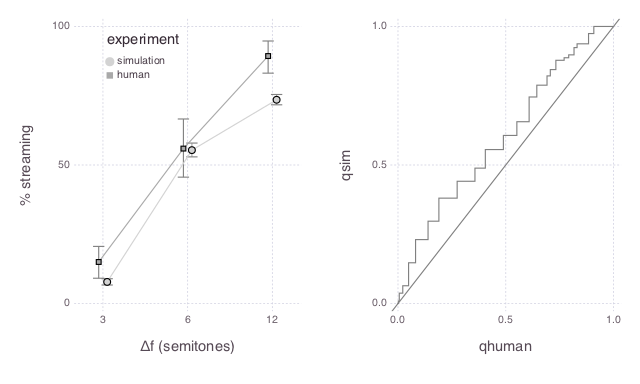

┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ xintercept
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/Gadfly.jl:484


false

In [96]:
p = plot_fit(df,params,t_c_a=15,t_c_m=44)
draw(PDF(joinpath(plotdir,"fig2bc.pdf"),5inch,3inch),p)
draw(PNG(6.666inch,4inch),p)

# Figure 4A

In [112]:
HERR

(stream = 0.13381068338879099, lengths = 0.10400423231045725)

In [147]:
hstr,hlen = human_error_by_sid(resample=50);

In [161]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(params,fields) do row
    next!(progress)
    m = model_error(df,params;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = m.stream,length_error = m.lengths,eratio = error_ratio(m))
end

dfplot_ind = @linq df_summary |>
    rename_levels_for([:stream_error,:length_error,:eratio]) |>
    transform(a = packaxes(:c_a), m = packaxes(:c_m), rand = randn(length(:c_a))) |>
    transform(eratio_str = fmt.("01.2f",:eratio),
              stream_error_str = map(x -> x[2:end],fmt.("0.3f",:stream_error)))
              
head(dfplot)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


,c_a,c_m,level,stream_error,a,m,stream_error_str
,Float64,Float64,String,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,0.163327,0.0,0.0,.163
2,0.0,5.0,Peripheral,0.0970272,0.0,1.5,.097
3,0.0,63.0,Peripheral,0.164825,0.0,2.5,.165
4,0.0,790.0,Peripheral,0.144174,0.0,3.5,.144
5,0.0,10000.0,Peripheral,0.135415,0.0,4.5,.135
6,5.0,0.0,Peripheral,0.0947398,1.5,0.0,.095


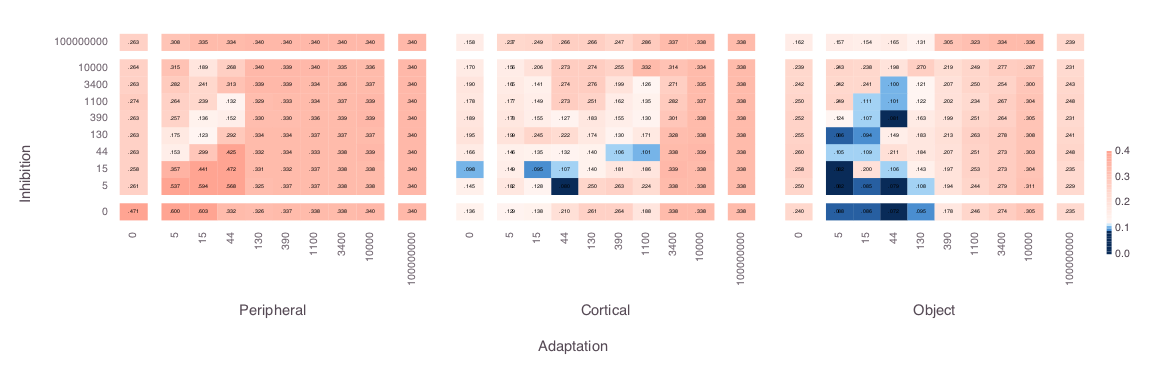

false

In [190]:
xvals = sort!(unique(dfplot_ind.a));
yvals = sort!(unique(dfplot_ind.m));

pl = plot(dfplot_ind,x=:a,y=:m,color=:stream_error,xgroup=:level,label=:stream_error_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot_ind.c_a)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot_ind.c_m)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0,maxvalue=0.4,colormap=colorscale("RdBu",reverse=true,minvalue=0.0,maxvalue=0.4,colorstop=0.8,colorstart=0.075,midvalue=mean(hstr.x1))),
     Guide.colorkey(title=""),
     Theme(grid_line_width=0inch,point_label_font_size=4pt,point_label_color=colorant"black"))
draw(PDF(joinpath(plotdir,"fig4A.pdf"),8inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

# Figure 4B

In [126]:
datadir_all = joinpath("..","data","count_lengths","run_2018-11-28")
datadir_selected = joinpath("..","data","count_lengths","run_2018-11-30")

"../data/count_lengths/run_2018-11-30"

In [152]:
params_all = load_params(joinpath(datadir_all,"params.jld2"))
params_all[:pindex] = 1:size(params_all,1)
settings = joinpath(srcdir,"settings.toml")

results = []
for_results_in(joinpath(datadir_all,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df_all = vcat(results...);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


In [153]:
params_selected = load_params(joinpath(datadir_selected,"params.jld2"))
params_selected[:pindex] = 1:size(params_selected,1)
settings = joinpath(srcdir,"settings.toml")

results = []
for_results_in(joinpath(datadir_selected,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df_selected = vcat(results...);

Progress:  43%|██████████████████                       |  ETA: 0:00:12

InterruptException: InterruptException:

In [154]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params_all[fields])))
df_summary_all = by(params_all,fields) do row
    next!(progress)
    m = model_error(df_all,params_all;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = m.stream,eratio = error_ratio(m),pindex = row.pindex[1])
end

Progress:   3%|█                                        |  ETA: 0:02:19

InterruptException: InterruptException:

In [155]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params_selected[fields])))
df_summary_selected = by(params_selected,fields) do row
    next!(progress)
    m = model_error(df_selected,params_selected;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = m.stream,eratio = error_ratio(m),pindex = row.pindex[1])
end

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:01┌ Warning: Expected 3 parameter entries. 
│   
Instead, only found entires:  = 
Instead, only found entires: 
│   string(found) = 2×36 DataFrame
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f         │ t_W_m_c │ t_c_x   │ f_c_x   │ t_W_m_σ_t │ s_τ_σ     │ f_c_a   │ f_c_σ   │ s_c_m   │ f_τ_a     │ s_c_σ   │ Δt        │ s_τ_m     │ s_c_x   │ t_W_m_σ_ϕ │ t_τ_a     │ s_c_a   │ t_τ_m     │ t_c_σ   │ t_τ_x     │ s_W_m_c │ s_τ_a     │ f_W_m_c │ t_τ_σ     │ f_τ_σ     │ f_τ_x     │ Δf    │ t_W_m_σ_N │ f_τ_m     │ s_τ_x     │ s_W_m_σ │ pindex │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Float64 │ Float64 │ Float64   │ Quantity… │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Quantity… │ Quantity… │ Float64 │ Float64   │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Quantity… │ Quantity… │ Int64 │ Float64   │ Quantity… │ Quantity… │ Float

,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,stream_error,eratio,pindex
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,5.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.127253,0.617554,1
2,5.0,5.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.425201,1.75818,2
3,5.0,63.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.135626,0.702271,3
4,5.0,0.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.151003,0.71139,4
5,5.0,5.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.425953,1.75207,5
6,5.0,63.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.136147,0.697413,6
7,5.0,0.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.143743,0.693429,7
8,5.0,5.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.413952,1.70153,8
9,5.0,63.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.135751,0.678761,9


In [156]:
# if there is a selected entry with a revised eratio, use that value

df_summary_selected[:procedure] = "selected"
df_summary_all[:procedure] = "survey"
function favor_selected(vals,procedure)
    selected = findfirst(procedure .== "selected")
    if selected isa Nothing
        @assert length(vals) == 1
        first(vals)
    else
        vals[selected]
    end
end
    
df_summary = @linq vcat(df_summary_all,df_summary_selected) |>
    by(fields,stream_error = favor_selected(:stream_error,:procedure))
head(df_summary)

,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,stream_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.305391
2,0.0,5.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.282097
3,0.0,63.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462
4,0.0,790.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462
5,0.0,10000.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462
6,0.0,0.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.303121


In [157]:
mlevels = [(vars = [:f_c_a,:f_c_m], name = "Peripheral"),
          (vars = [:s_c_a,:s_c_m], name = "Cortical"),
          (vars = [:t_c_a,:t_c_m], name = "Object")]
dflevels = map(mlevels) do level
    result = by(df_summary,level.vars) do slice
       DataFrame(c_a = first(slice[level.vars[1]]),c_m = first(slice[level.vars[2]]),
                 level = level.name, stream_error = minimum(skipmissing(slice.stream_error)))
    end
    result[[:c_a,:c_m,:level,:stream_error]]
end
dfplot = @linq vcat(dflevels...) |>
    transform(a = packaxes(:c_a,maxpad=false), m = packaxes(:c_m,maxpad=false)) |>
    transform(stream_error_str = map(x -> x[2:end],fmt.("0.3f",:stream_error)))
head(dfplot)

,c_a,c_m,level,stream_error,a,m,stream_error_str
,Float64,Float64,String,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,0.163327,0.0,0.0,.163
2,0.0,5.0,Peripheral,0.0970272,0.0,1.5,.097
3,0.0,63.0,Peripheral,0.164825,0.0,2.5,.165
4,0.0,790.0,Peripheral,0.144174,0.0,3.5,.144
5,0.0,10000.0,Peripheral,0.135415,0.0,4.5,.135
6,5.0,0.0,Peripheral,0.0947398,1.5,0.0,.095


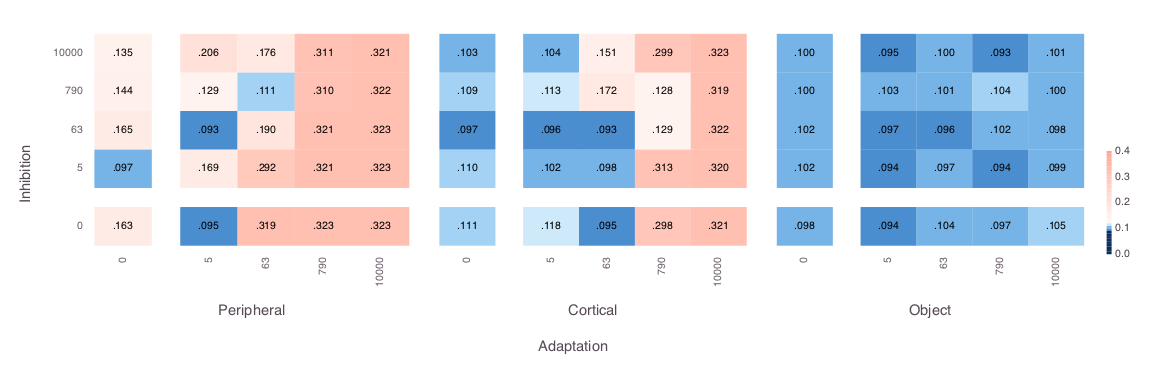

false

In [158]:
xvals = sort!(unique(dfplot.a));
yvals = sort!(unique(dfplot.m));

pl = plot(dfplot,x=:a,y=:m,color=:stream_error,xgroup=:level,label=:stream_error_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_a,maxpad=false)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_m,maxpad=false)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0,maxvalue=0.4,colormap=colorscale("RdBu",reverse=true,minvalue=0.0,maxvalue=0.4,colorstop=0.8,colorstart=0.075,midvalue=mean(hstr.x1))),
     Guide.colorkey(title=""),
     Theme(grid_line_width=0inch,point_label_font_size=8pt,point_label_color=colorant"black"))
draw(PDF(joinpath(plotdir,"fig4B.pdf"),7.75inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

In [ ]:
# TODO: bootstrap these estimates (probably speed up rms estimation first? or run on cluster??)

In [101]:
stats = by(vcat(dflevels...),:level) do x
    DataFrame(mean = mean(skipmissing(x.eratio)),min = minimum(skipmissing(x.eratio)))
end

,level,mean,min
,String,Float64,Float64
1,Peripheral,1.04424,0.439445
2,Cortical,0.837476,0.439445
3,Object,0.490771,0.439445


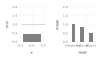

In [102]:
pl = hstack(plot(stats[stats.level.=="Cortical",:],x=[0],y=:min,intercept=[1.0],slope=[0],
                 Geom.bar,Geom.abline,Coord.cartesian(ymax=2.0),bartheme),
            plot(stats,x=:level,y=:mean,
                 Geom.bar,Coord.cartesian(ymax=2.0),Guide.xticks(orientation=:horizontal),bartheme))
draw(SVG(4inch,2.5inch),pl)
draw(PDF(joinpath(plotdir,"fig3D.pdf"),4inch,2.5inch),pl)

# Figure 4C

In [20]:
using DependentBootstrap

In [143]:
head(dfplot)

,c_a,c_m,level,stream_error,a,m,stream_error_str
,Float64,Float64,String,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,0.163327,0.0,0.0,.163
2,0.0,5.0,Peripheral,0.0970272,0.0,1.5,.097
3,0.0,63.0,Peripheral,0.164825,0.0,2.5,.165
4,0.0,790.0,Peripheral,0.144174,0.0,3.5,.144
5,0.0,10000.0,Peripheral,0.135415,0.0,4.5,.135
6,5.0,0.0,Peripheral,0.0947398,1.5,0.0,.095


In [178]:
hstr,hlen = human_error_by_sid(resample=50);
dfstr_ind = vcat(DataFrame(kind=dfplot_ind.level,error=dfplot_ind.stream_error),DataFrame(kind="human",error=hstr.x1));
dfstr = vcat(DataFrame(kind=dfplot.level,error=dfplot.stream_error),DataFrame(kind="human",error=hstr.x1));

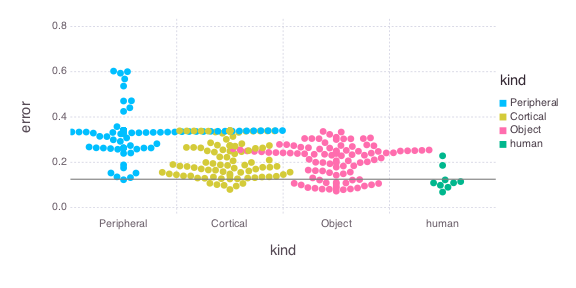

In [189]:
strplot = plot(dfstr_ind,y=:error,x=:kind,color=:kind,intercept=[mean(hstr.x1)],slope=[0],Geom.abline,Geom.beeswarm,bartheme)
draw(PNG(6inch,3inch),strplot)
draw(PDF("fig4c.pdf",6inch,4inch),strplot)

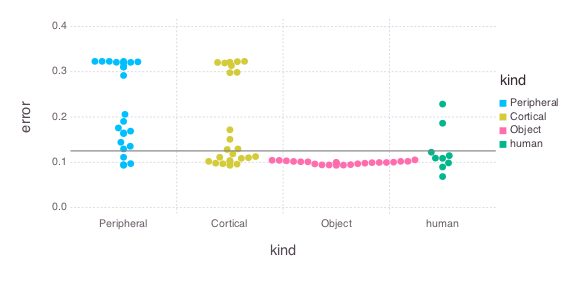

In [188]:
strplot = plot(dfstr,y=:error,x=:kind,color=:kind,intercept=[mean(hstr.x1)],slope=[0],Geom.abline,Geom.beeswarm,bartheme)
draw(PNG(6inch,3inch),strplot)
draw(PDF("fig4d.pdf",6inch,4inch),strplot)

In [84]:
bootstats = CSV.read("bootstats.csv")
head(bootstats)

,level,mean,min
,String⍰,Float64⍰,Float64⍰
1,Peripheral,1.68762,0.628241
2,Cortical,1.21146,0.471629
3,Object,1.0195,0.354392
4,Peripheral,1.68193,0.607623
5,Cortical,1.2098,0.481483
6,Object,1.02037,0.378065


In [67]:
num_sims = 20
allbootstats = []
params6 = @where(params,:Δf .== 6)
@showprogress for indices in dbootinds(1:num_sims,numresample=100)
    df_summary = by(params6,fields) do row
        m = model_error(df,params;(k => row[1,k] for k in fields)...)
        DataFrame(eratio = error_ratio(m))
    end
    push!(allbootstats,by(rename_levels_for(df_summary,:eratio),:level) do x
        DataFrame(mean = mean(x.eratio),min = minimum(x.eratio))
    end)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


In [68]:
bootstats = vcat(allbootstats...)
CSV.write("bootstats.csv",bootstats)

"bootstats.csv"

In [69]:
stats = by(bootstats,:level) do x
    meanl,meanu = quantile(skipmissing(x.mean),[0.025,0.975])
    minl,minu = quantile(skipmissing(x.min),[0.025,0.975])
    DataFrame(mean = mean(skipmissing(x.mean)),meanl = meanl,meanu = meanu,
        min = mean(skipmissing(x.min)),minl = minl,minu = minu)
end

,level,mean,meanl,meanu,min,minl,minu
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Peripheral,1.89444,1.89444,1.89444,0.636826,0.636826,0.636826
2,Cortical,1.59681,1.59681,1.59681,0.388901,0.388901,0.388901
3,Object,0.985022,0.985022,0.985022,0.394952,0.394952,0.394952


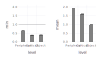

In [71]:
pl = hstack(plot(stats,x=:level,y=:min,ymin=:minl,ymax=:minu,intercept=[1.0],slope=[0],
                Geom.errorbar,Geom.bar,Geom.abline,Coord.cartesian(ymax=2.0),Guide.xticks(orientation=:horizontal),bartheme),
            plot(stats,x=:level,y=:mean,ymin=:meanl,ymax=:meanu,Geom.errorbar,
                Geom.bar,Coord.cartesian(ymax=2.0),bartheme,Guide.xticks(orientation=:horizontal)))
draw(SVG(4inch,2.5inch),pl)
draw(PDF(joinpath(plotdir,"fig3B.pdf"),4inch,2.5inch),pl)